In [9]:
from datetime import datetime
from datetime import timedelta
import psycopg2
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
import pandas as pd

import seaborn as sns
sns.set(style="whitegrid")

8/25/18

Wetwell flow modeling, specific to the Franklin St Pump station. 

Data is collected from two sources:
    a spreadsheet containing wetwell volume in 6 inch increments through the wetwell's height
    a Postgres database containing wetwell elevation readings for the past year in 20 second increments
    
The model extracts the data from the two sources, determines the elevation drawdown events, applies the start/end elevations to the
spreadsheet values, and then determines the volume pumped down.

TODO:
Port script to using dataframes instead of lists

In [2]:
# Postgres Connection
conn = psycopg2.connect("dbname='Pump Data' user='postgres' host='localhost' password=''")
cur = conn.cursor()

# Excel Connection
workBook = r'C:\Users\jheath\Documents\JupyterNotebooks\postgres\Franklin_Vol_r.xlsx'  # s
wb = openpyxl.load_workbook(workBook, data_only=True)
headers = [r'gallons',r'Ele']  # headers within the spreadsheet

time_format = '%Y-%m-%d %H:%M:%S'

In [3]:
def list_of_rows(wb,headers):
    """
    This function uses openpyxl to grab the excel data. Pandas would be better.
    
    wb: excel workbook
    headers: columns from which to grab data
    """
    unmerged = []  # list of daat pulled from spreadsheet
    location_col_index = []  # index of the ele/gallons columns
    sheet = wb.worksheets[0]
    row_gen = sheet.iter_rows(max_row=1)
    
    for row in row_gen:  # max_rows set to one, just iterates through header row
        for cell in row:
            if cell.value in headers:
                location_col_index.append(cell.col_idx)

    col_gen = sheet.iter_cols(min_col=location_col_index[0],
                                 max_col=location_col_index[-1])

    for col in col_gen:  # col_gen is set to just contain the columns in the header list
        for cell in col:
            if cell.col_idx in location_col_index:
                
                if cell.value not in headers:
                    unmerged.append(cell.value)

    # because all values are placed inton one bit list
    # list is simply split in two to form two lists
    ele = unmerged[:int(len(unmerged)/2)]
    gal = unmerged[int(len(unmerged)/2):]

    return zip(ele,gal) # creates nested lists

def intersperse(lst):
    """
    Estimation for a smoother WW slope. Pulls in the know elevation/volume values
    and tries to define the volume values in 3 inch increments, expanding apon the
    given 6 inch increments. Adds a tiny bit of accuracy.
    """
    new_list = []
    for i in lst:
        try:
            slope = i[0] / i[1]
            first = i[0]- .06,(i[0]- .06) // slope  # 3 inches below actual
            second = i[0], i[1] # Actual value
            last = i[0]+ .06,(i[0]+ .06) // slope  # 3 inches above actual
            new_list.append(first)
            new_list.append(second)
            new_list.append(last)
            
        except: pass

    return new_list

def wetwell_db_collect(min_time,max_time):
    """
    This function pulls in the Wetwell data from the Postgres connection, from within the time selection,
    and returns a list of elevations values and time
    
    min_time: beginning of time window
    max_time: end of time window
    """
    cur.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
    cur.execute('''SELECT * FROM "WetWell_Activity" WHERE("TagIndex" = '18') ORDER BY "DateAndTime" ASC''')
    
    x_y = []
    for row in cur.fetchall():
        temp_x = datetime.strptime(row[0], time_format)
        if temp_x > min_time:
            
            if temp_x < max_time:
                x_y.append([temp_x,row[3]])
                
    return x_y

def trough_magnitude(time_level):
    """This function iterates through a list and determines if the values
        are increasing or decreasing. If they are decreasing the itertator is
        in a trough, and once the values begin increasing the subist ends and the next
        trough is recorded in a separate list

        time_level: a list of (time,values)
        """
    
    temp = [[0,0]]
    trough = [[[0,0]]]
    trough_list = []

    # iterate through list of lists of (time,value)
    for time in time_level:
        time[1] = float(time[1])  # make sure the value is a float


        # within each list is list of (time,value)
        # if value less than/equal to temp's last input, add value to temp
        if time[1] <= temp[-1][1]:
            temp.append(time)

        # if value greater than temp's last input, add all of temp to
        # trough list and delete temp
        if time[1] > temp[-1][1]:

            trough.append(temp[:])
            del temp[:]
            temp.append(time)
            
    for i in trough[2:]:
        values = []
        dates = []
        for j in i:
        # iterate through the list of list and place all of the values
        # into one list, and all of the dates into another list
            values.append(j[1])
            dates.append(j[0])

        # the list of values is removed if there is only one unique within it
        # this ensures that the returns trough_list is only pump events
        if len(set(values)) > 1:
            print(values,dates)
            trough_list.append((dates,values))
    return trough_list


----

In [4]:
min_time = datetime.strptime('2018-08-19 23:59:59',time_format)
max_time = datetime.strptime('2018-08-21 00:00:00',time_format)
time_level = wetwell_db_collect(min_time,max_time)

To analyze a specific time period's flow a min time and a max time must be set, and then used to pull data from the postgres database.

----

In [5]:
%%capture  
trough = trough_magnitude(time_level)
ele_gals = intersperse(list_of_rows(wb,headers))

The wetwell data is then searched run through trough_magnitude function to search for pump down events. 
Then the elevation/volume data from the spreadsheet is given 3 inch increments with the intersperse function.

----

In [6]:
tot_pump = []  # total feet pumped down in each event
tot_time = []  # total time of each event
tot_gal = []  # total gallons pumped down in each event

for val in trough:  # iterates through each pump event recorded in the trough list

    # d1 is the start of the pump cycle, d2 is the end of the pump cycle
    d1 = datetime.strptime("{}".format(val[0][0]), "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime("{}".format(val[0][-1]), "%Y-%m-%d %H:%M:%S")
    
    dif = val[1][0] - val[1][-1]  # the total gallons pumped in this cycle
    period = d2-d1  # the total time this cycle took to complete
    
    temp_max = [] 
    temp_min = []  
    for e_g in ele_gals:  # used to determine the volume for each pump level reported. 
                          # Rounds to the nearest 3 inches of elevation
        if e_g[0] <= float(val[1][0]):
            temp_max.append(e_g)
        if e_g[0] <= float(val[1][-1]):
            temp_min.append(e_g)

    tot_gal.append(temp_max[-1][1]-temp_min[-1][1])
    tot_time.append(period)
    tot_pump.append(dif)

There is now a list containing each trough event in the wetwell data (indicating a pump down event) and a list of elevaton values paired to volumes.

From these two lists total pumped down feet (tot_pump), total time of each pump event (tot_time), and total gallons pumped (tot_gal) can be determined.

------

# Plotting

Total Pumped: 868738.08 Gallons
Pump Run Time: 10:12:20
Total Time Period 1 day, 0:00:01
GPM while pump on: 1418.73
Mean pump event: 8434.35 Gallons


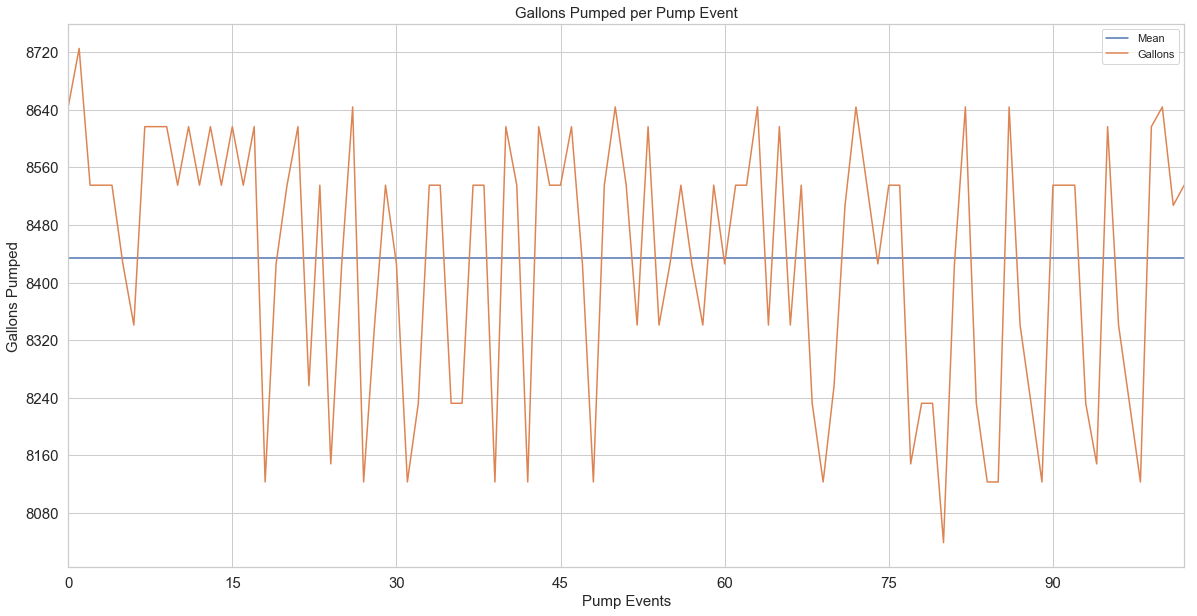

In [13]:
tot_time_full = timedelta(0)
for tot in tot_time:
    tot_time_full += tot

del tot_gal[0]  # first entry is bisected by the time split and need to be deleted.

print("Total Pumped:",round(sum(tot_gal),2),"Gallons") 
print("Pump Run Time:",tot_time_full)
print("Total Time Period",max_time - min_time)
print("GPM while pump on:",round(sum(tot_gal)/tot_time_full.total_seconds()*60,2))
print("Mean pump event:",round(np.mean(tot_gal),2),"Gallons")

# Plotting Pump Events
fig,ax = plt.subplots()
ax.set(xlabel = "Pump Events", ylabel= "Gallons Pumped",
               title= "Gallons Pumped per Pump Event")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

# Setting x axis to integer tick locations.
for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
plt.xlim(0,len(tot_gal)-1)
plt.plot([i for i in range(len(tot_gal))],[np.mean(tot_gal)]*len(tot_gal), label = "Mean")  # plotting the mean
plt.plot(tot_gal, label = 'Gallons')
ax.legend()
plt.show()

The above graph demonstrates the models' interpreation of the peak/trough wetwell data. 

Across 108 Pump events 903,068.74 gallons were estimated to have been pumped, in a 24 hour time period, with a mean of 8,439 across all pump events. And a GPM of 1,404.62 while the pump is on.

_____

Mean footage drop: 3.68


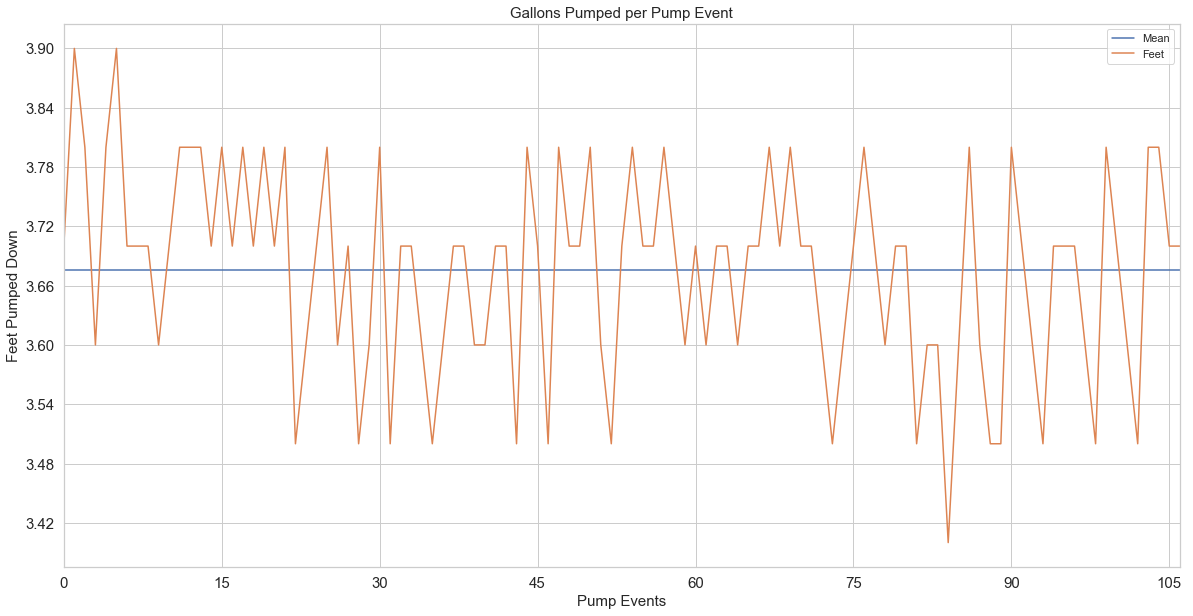

In [15]:
print('Mean footage drop:',round(np.mean(tot_pump),2))

del tot_pump[0]
fig,ax = plt.subplots()
ax.set(xlabel = "Pump Events", ylabel= "Feet Pumped Down",
               title= "Gallons Pumped per Pump Event")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

# Setting x axis to integer tick locations.
for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlim(0,len(tot_pump)-1)
plt.plot([i for i in range(len(tot_pump))],[np.mean(tot_pump)]*len(tot_pump), label = "Mean")  # plotting the mean
plt.plot(tot_pump, label = 'Feet')
ax.legend()
plt.show()

The above graph shows another way to represent the data, by plotting Feet Pumped Down over Pump Events. This owuld be less meaningfull than total gallons pumped. However, in a wet-weather event it may be useful to track how high the wetwell is getting, and compare those vlaues to report alarms to ensure the alarms are functioning properly. Especially since the model struggles to properly report wet weather flow.

_______

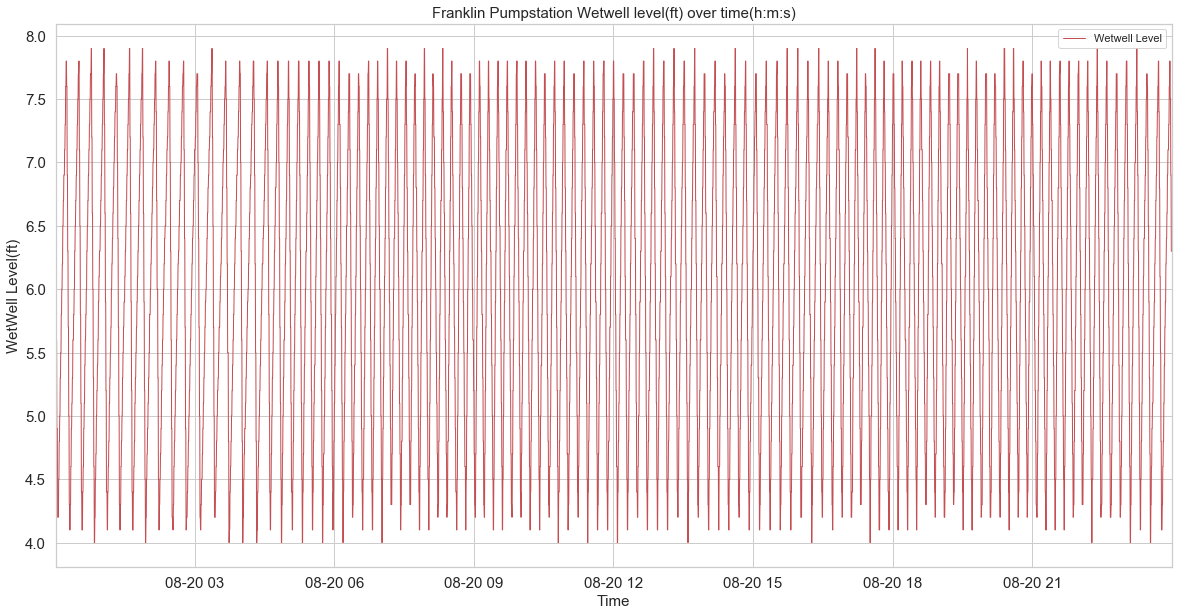

In [16]:
dates = []
ft = []

for vals in time_level:
    x,y = vals
    dates.append(x)
    ft.append(y)


fig,ax = plt.subplots()
ax.set(xlabel='Time', ylabel='WetWell Level(ft)', 
       title='Franklin Pumpstation Wetwell level(ft) over time(h:m:s)')


dates = matplotlib.dates.date2num(dates)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.rcParams["figure.figsize"] = fig_size
plt.plot_date(dates, ft,'r-', linewidth=1, label = 'Wetwell Level') 
plt.xlim(dates[0],dates[-1])
ax.legend()
plt.show()

As stated above, the model struggles with wet-weather events. In a Wet-weather event the wetwell may remain at max elevation for several minutes, with the pump on and pumping at near full capacity. However, since the model determines flow by examining the downward trends, it cannot compute flow from a flat line. It is helpful to plot the Wetwell Level over Time to determine if any of these flat-line events occured. 

In a wet-weather flatline the max GPM of the pumpstation is then substituted (not here) to determine flow. But, as can be seen here, this time period contained only wet-weather flow.